In [292]:
#Import packages
import json
import sklearn
import numpy as np
import pandas as pd

In [293]:
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import f_classif, chi2, SelectPercentile

In [294]:
#Load datasets
with open("domain1_train_data.json", "r") as f:
    dataset_1 = [ json.loads(line, parse_int = str) for line in f ]

with open("domain2_train_data.json", "r") as f:
    dataset_2 = [ json.loads(line, parse_int = str) for line in f ]

with open("test_data.json", "r") as f:
    testset = [ json.loads(line, parse_int = str) for line in f ]

n_samples_1 = len(dataset_1)
n_samples_2 = len(dataset_2)
n_tests = len(testset)

In [295]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

def get_vectorizer( texts: list[str], *, method="countvectorize", **kwargs ):
    """From a list of texts, output an appropriate vectorizer either using CountVectorizer or TF-IDF depending on method argument. 

     Args:
         texts (list[str]): list of strings, each item corresponding to a text.
         method (str, optional): Method to select features. Defaults to "count-vectorizer".
         **kwargs: kwarg arguments to pass to Vectorizer classes of sklearn.
    Raises:
        ValueError: If passing an non-specified method of text feature extraction

     Returns:
         pd.DataFrame: dataframe of shape (n_samples, n_features)
    """
    
    #We want single digits to tokenized. This regex considers everything as a token except whitespace.
    kwargs['token_pattern'] = r'\S+' 
    if method == "countvectorize":
        vectorizer = CountVectorizer(**kwargs)
    elif method == "tfidf":
        vectorizer = TfidfVectorizer(**kwargs)
    else:
        raise ValueError(f"{method} is not a supported method.")
    
    #Use texts to initialize vocabulary of vectorizer
    vectorizer.fit(texts)
    return vectorizer

In [296]:
#First, create sentences (documents) from list of words for each instance in two domains
datatexts_1 = []
datatexts_2 = []
for instance in dataset_1:
    datatexts_1 += [ " ".join(instance["text"]) ]
for instance in dataset_2:
    datatexts_2 += [ " ".join(instance["text"]) ]

# label 0 for domain 1, label 1 for domain 2.
y = np.array( [ 0 ]*len(datatexts_1) + [ 1 ]*len(datatexts_1) )

#For later: do the same for test set
test_texts = []
for instance in testset:
    test_texts += [" ".join(instance["text"])] 

In [297]:
method = 'tfidf' 
use_idf = False
use_idf = True
n_gram_max = 3 #max length of sequence of words to consider as a feature
vectorizer = get_vectorizer(texts = datatexts_1 + datatexts_2 + test_texts, #Include all vocab throughout dataset to have same feature space
                                method=method,
                                use_idf=use_idf,
                                ngram_range=(1,n_gram_max),
                                max_df=0.999, #Ignore vocabulary appearing too frequently, probably words like "is", "are", "and", "this" etc.
                                min_df=10, #Ignore vocabulary that is too infrequent, as this may lead to low prediction accuracy.
                                )
n_classifier_features = vectorizer.get_feature_names_out().size
print(f"vocabulary size: {n_classifier_features}")

vocabulary size: 128509


In [298]:
vocab_idx = vectorizer.vocabulary_

In [299]:
idx_vocab = {v:u for u,v in vocab_idx.items()}

In [300]:
def term_frequency_counter(text):
    counter = {}
    appearances = set({})
    for i, word in enumerate(text):
        counter[word] = counter.get(word, 0) + 1/(len(text))
        appearances.add(word)
        if i < len(text) - 1:
            gram = f"{word} {text[i+1]}"
            counter[gram] = counter.get(gram, 0) + 1/(len(text)-1)
            appearances.add(gram)
        if i < len(text) - 2:
            gram = f"{word} {text[i+1]} {text[i+2]}"
            counter[gram] = counter.get(gram, 0) + 1/(len(text)-2)
            appearances.add(gram)
    return counter, appearances

In [301]:
human_frequentcounter_1 = {vocab: 0 for vocab in vocab_idx}
human_documentcounter_1 = {vocab: 0 for vocab in vocab_idx}
machine_frequentcounter_1 = {vocab: 0 for vocab in vocab_idx}
machine_documentcounter_1 = {vocab: 0 for vocab in vocab_idx}

for human_instance in dataset_1[:2500]:
    human_text = human_instance["text"]
    counter, appearances = term_frequency_counter( human_text )
    for vocab, freq in counter.items():
        if vocab in vocab_idx:
            human_frequentcounter_1[vocab] += freq / 2500
    for vocab in appearances:
        if vocab in vocab_idx:
            human_documentcounter_1[vocab] += 1 / 2500
                

for machine_instance in dataset_1[2500:]:
    machine_text = machine_instance["text"]
    counter, appearances = term_frequency_counter( machine_text )
    for vocab, freq in counter.items():
        if vocab in vocab_idx:
            machine_frequentcounter_1[vocab] += freq / 2500
    for vocab in appearances:
        if vocab in vocab_idx:
            machine_documentcounter_1[vocab] += 1 / 2500

In [302]:
human_frequentcounter_2 = {vocab: 0 for vocab in vocab_idx}
human_documentcounter_2 = {vocab: 0 for vocab in vocab_idx}
machine_frequentcounter_2 = {vocab: 0 for vocab in vocab_idx}
machine_documentcounter_2 = {vocab: 0 for vocab in vocab_idx}

for human_instance in dataset_2[:1500]:
    human_text = human_instance["text"]
    counter, appearances = term_frequency_counter( human_text )
    for vocab, freq in counter.items():
        if vocab in vocab_idx:
            human_frequentcounter_2[vocab] += freq / 1500
    for vocab in appearances:
        if vocab in vocab_idx:
            human_documentcounter_2[vocab] += 1 / 1500
                

for machine_instance in dataset_2[1500:]:
    machine_text = machine_instance["text"]
    counter, appearances = term_frequency_counter( machine_text )
    for vocab, freq in counter.items():
        if vocab in vocab_idx:
            machine_frequentcounter_2[vocab] += freq / 11500
    for vocab in appearances:
        if vocab in vocab_idx:
            machine_documentcounter_2[vocab] += 1 / 11500

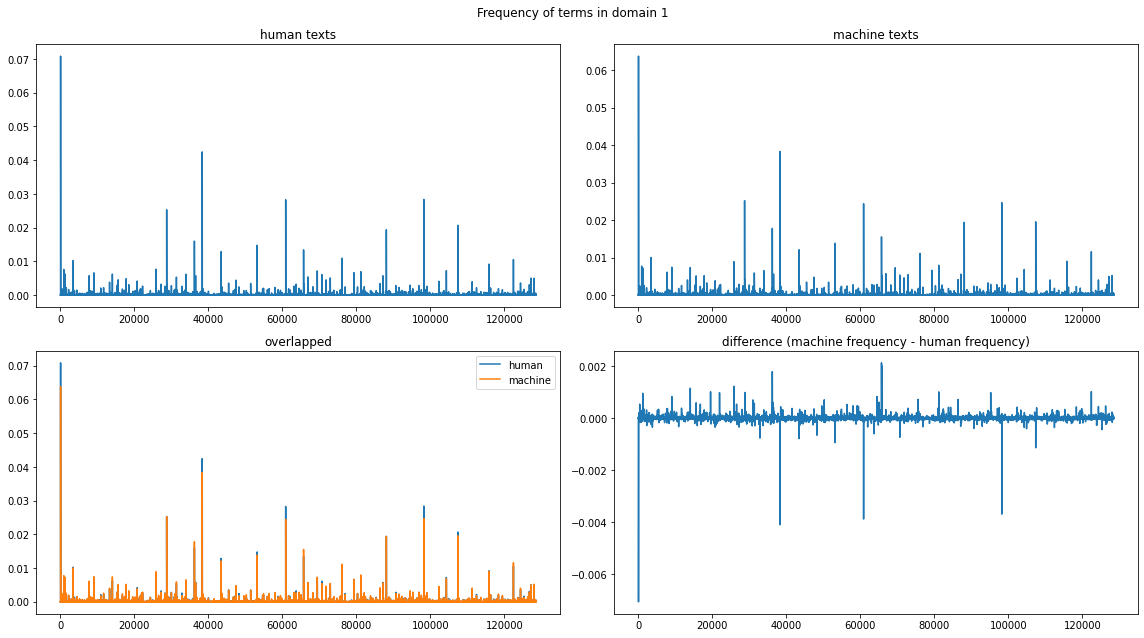

In [303]:
#Sorted by index ordering:
n_classifier_features = 128509
import matplotlib.pyplot as plt
fig, axs = plt.subplots( nrows =2, ncols = 2, figsize=(16,9) )
fig.suptitle( "Frequency of terms in domain 1" )
axs[0,0].plot( range(n_classifier_features), [ human_frequentcounter_1[idx_vocab[i]] for i in range(n_classifier_features) ] )
axs[0,0].set_title( "human texts" )

axs[0,1].plot( range(n_classifier_features), [ machine_frequentcounter_1[idx_vocab[i]] for i in range(n_classifier_features) ] )
axs[0,1].set_title( "machine texts" )

axs[1,0].plot( range(n_classifier_features), [ human_frequentcounter_1[idx_vocab[i]] for i in range(n_classifier_features) ], label="human" )
axs[1,0].plot( range(n_classifier_features), [ machine_frequentcounter_1[idx_vocab[i]] for i in range(n_classifier_features) ], label="machine" )
axs[1,0].set_title( "overlapped" )
axs[1,0].legend()

axs[1,1].plot( range(n_classifier_features), [ machine_frequentcounter_1[idx_vocab[i]] - human_frequentcounter_1[idx_vocab[i]] for i in range(n_classifier_features) ] )
axs[1,1].set_title( "difference (machine frequency - human frequency)" )

fig.tight_layout()
fig.show()

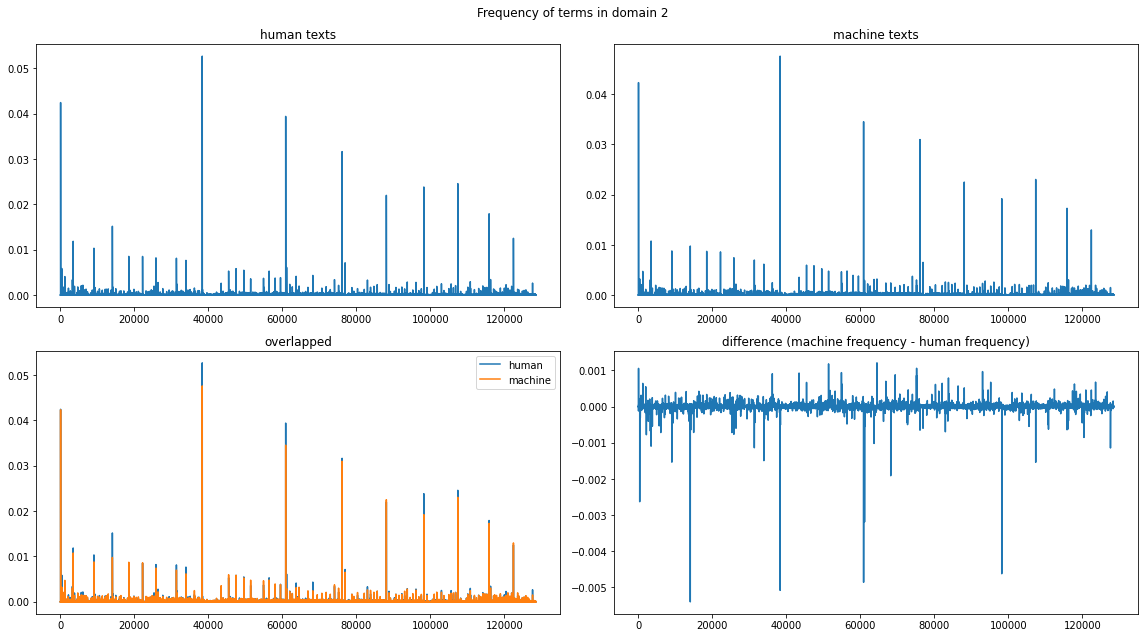

In [304]:
#Sorted by index ordering:
import matplotlib.pyplot as plt
fig, axs = plt.subplots( nrows =2, ncols = 2, figsize=(16,9) )
fig.suptitle( "Frequency of terms in domain 2" )
axs[0,0].plot( range(n_classifier_features), [ human_frequentcounter_2[idx_vocab[i]] for i in range(n_classifier_features) ] )
axs[0,0].set_title( "human texts" )

axs[0,1].plot( range(n_classifier_features), [ machine_frequentcounter_2[idx_vocab[i]] for i in range(n_classifier_features) ] )
axs[0,1].set_title( "machine texts" )

axs[1,0].plot( range(n_classifier_features), [ human_frequentcounter_2[idx_vocab[i]] for i in range(n_classifier_features) ], label="human" )
axs[1,0].plot( range(n_classifier_features), [ machine_frequentcounter_2[idx_vocab[i]] for i in range(n_classifier_features) ], label="machine" )
axs[1,0].set_title( "overlapped" )
axs[1,0].legend()

axs[1,1].plot( range(n_classifier_features), [ machine_frequentcounter_2[idx_vocab[i]] - human_frequentcounter_2[idx_vocab[i]] for i in range(n_classifier_features) ] )
axs[1,1].set_title( "difference (machine frequency - human frequency)" )

fig.tight_layout()
fig.show()

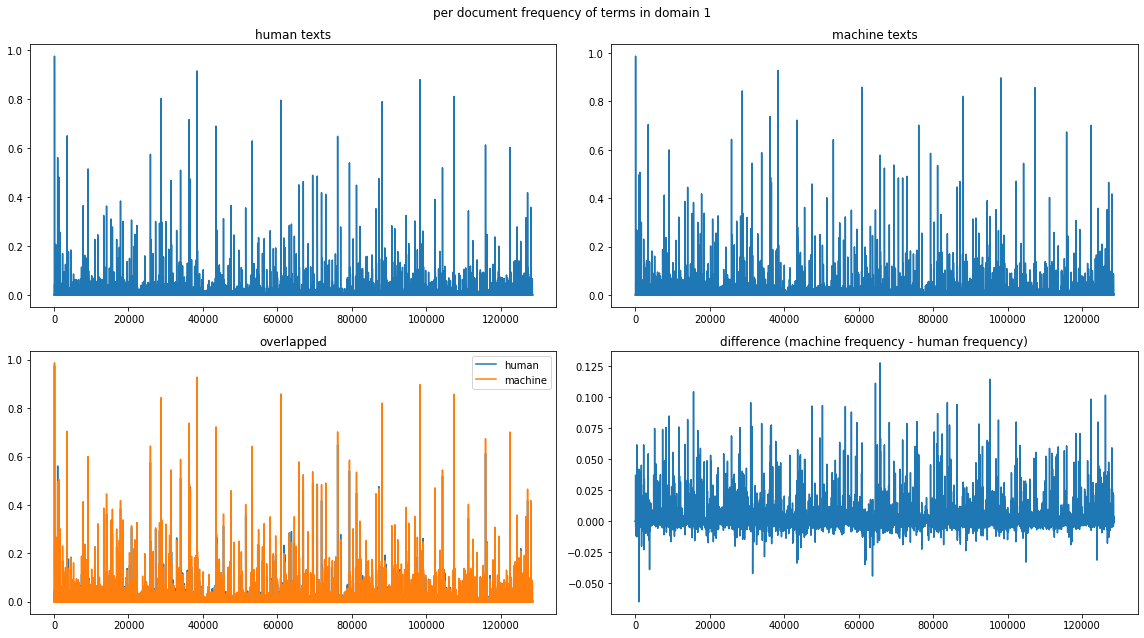

In [305]:
#Sorted by index ordering:
import matplotlib.pyplot as plt
fig, axs = plt.subplots( nrows =2, ncols = 2, figsize=(16,9) )
fig.suptitle( "per document frequency of terms in domain 1" )
axs[0,0].plot( range(n_classifier_features), [ human_documentcounter_1[idx_vocab[i]] for i in range(n_classifier_features) ] )
axs[0,0].set_title( "human texts" )

axs[0,1].plot( range(n_classifier_features), [ machine_documentcounter_1[idx_vocab[i]] for i in range(n_classifier_features) ] )
axs[0,1].set_title( "machine texts" )

axs[1,0].plot( range(n_classifier_features), [ human_documentcounter_1[idx_vocab[i]] for i in range(n_classifier_features) ], label="human" )
axs[1,0].plot( range(n_classifier_features), [ machine_documentcounter_1[idx_vocab[i]] for i in range(n_classifier_features) ], label="machine" )
axs[1,0].set_title( "overlapped" )
axs[1,0].legend()

axs[1,1].plot( range(n_classifier_features), [ machine_documentcounter_1[idx_vocab[i]] - human_documentcounter_1[idx_vocab[i]] for i in range(n_classifier_features) ] )
axs[1,1].set_title( "difference (machine frequency - human frequency)" )

fig.tight_layout()
fig.show()

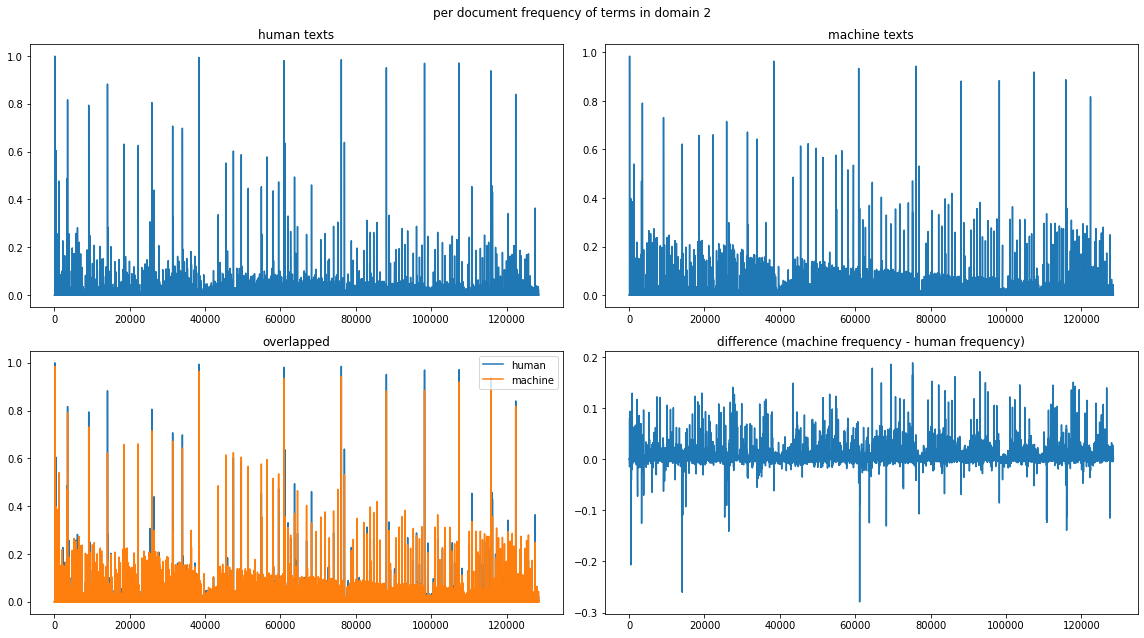

In [306]:
#Sorted by index ordering:
import matplotlib.pyplot as plt
fig, axs = plt.subplots( nrows =2, ncols = 2, figsize=(16,9) )
fig.suptitle( "per document frequency of terms in domain 2" )
axs[0,0].plot( range(n_classifier_features), [ human_documentcounter_2[idx_vocab[i]] for i in range(n_classifier_features) ] )
axs[0,0].set_title( "human texts" )

axs[0,1].plot( range(n_classifier_features), [ machine_documentcounter_2[idx_vocab[i]] for i in range(n_classifier_features) ] )
axs[0,1].set_title( "machine texts" )

axs[1,0].plot( range(n_classifier_features), [ human_documentcounter_2[idx_vocab[i]] for i in range(n_classifier_features) ], label="human" )
axs[1,0].plot( range(n_classifier_features), [ machine_documentcounter_2[idx_vocab[i]] for i in range(n_classifier_features) ], label="machine" )
axs[1,0].set_title( "overlapped" )
axs[1,0].legend()

axs[1,1].plot( range(n_classifier_features), [ machine_documentcounter_2[idx_vocab[i]] - human_documentcounter_2[idx_vocab[i]] for i in range(n_classifier_features) ] )
axs[1,1].set_title( "difference (machine frequency - human frequency)" )

fig.tight_layout()
fig.show()

In [384]:
frequency_tol = 0.0001 #The vocab frequency mean need to differ by at least .001% of length of entire corpus (combined texts).
document_tol = 0.001 #The feature means need to differ by at least 1% of documents

In [385]:
vocab_final = set({})
for vocab in vocab_idx:
    if abs(human_frequentcounter_1[vocab] - machine_frequentcounter_1[vocab]) >= frequency_tol:
        vocab_final.add( vocab )
    if abs(human_frequentcounter_1[vocab] - machine_frequentcounter_1[vocab]) >= frequency_tol:
        vocab_final.add( vocab )
    if abs(human_documentcounter_1[vocab] - machine_documentcounter_1[vocab]) >= document_tol:
        vocab_final.add( vocab )
    if abs(human_documentcounter_1[vocab] - machine_documentcounter_1[vocab]) >= document_tol:
        vocab_final.add( vocab )

In [386]:
len(vocab_final)

22962

In [387]:
vocab_final = list(vocab_final)

In [388]:
method = 'tfidf' 
use_idf = False
use_idf = True
n_gram_max = 3 #max length of sequence of words to consider as a feature
new_vectorizer = get_vectorizer(texts=datatexts_1+datatexts_2+test_texts, #Include all vocab throughout dataset to have same feature space
                                method=method,
                                use_idf=use_idf,
                                ngram_range=(1,n_gram_max),
                                max_df=0.999, #Ignore vocabulary appearing too frequently, probably words like "is", "are", "and", "this" etc.
                                min_df=10, #Ignore vocabulary that is too infrequent, as this may lead to low prediction accuracy,
                                vocabulary=vocab_final
                                )
n_classifier_features = new_vectorizer.get_feature_names_out().size
print(f"\tdomain classifier: {n_classifier_features}")

	domain classifier: 22962


In [389]:
from sklearn.linear_model import LogisticRegressionCV, LogisticRegressionCV
from sklearn.svm import SVC

In [390]:
from sklearn.feature_selection import f_classif, SelectPercentile

In [501]:
scaler = StandardScaler()

In [484]:
X = new_vectorizer.transform( datatexts_1 )
# selector = SelectPercentile( f_classif, percentile=50 )
# X = selector.fit_transform(X, y)

In [485]:
y = np.array( [1]*2500 + [0]*2500 )

In [546]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,shuffle=True,stratify=y,random_state=202)

In [547]:
X_train = scaler.fit_transform(X_train.toarray())
X_test = scaler.transform(X_test.toarray())

In [550]:
clf = LogisticRegressionCV(Cs=[0.001], scoring='balanced_accuracy' )
clf.fit(X_train,y_train)
clf.score(X_test,y_test)

0.883

In [549]:
clf.C_

array([0.001])

In [551]:
X_scaled = scaler.transform( X.toarray() )
clf.fit(X_scaled, y)

LogisticRegressionCV(Cs=[0.001], scoring='balanced_accuracy')

In [552]:
clf.score( X_scaled,y )

0.9996

In [553]:
X2 = new_vectorizer.transform( datatexts_2 )
y2 = np.array( [1]*1500 + [0]*11500 )

In [554]:
from sklearn.metrics import balanced_accuracy_score

In [560]:
def evaluation( classifier, X, y ):
    y_pred = classifier.predict(X)
    return balanced_accuracy_score(y, y_pred, adjusted=False)

In [556]:
X_train, X_test, y_train, y_test = train_test_split(X2,y2,test_size=0.2,shuffle=True,stratify=y2,random_state=12591)
scaler2 = StandardScaler()
scaler2.fit_transform( X_train.toarray() )
scaler2.transform( X_test.toarray() )

array([[ 0.        , -0.01438604, -0.02809019, ..., -0.0649182 ,
        -0.0222039 , -0.00980628],
       [ 0.        , -0.01438604, -0.02809019, ..., -0.0649182 ,
        -0.0222039 , -0.00980628],
       [ 0.        , -0.01438604, -0.02809019, ..., -0.0649182 ,
        -0.0222039 , -0.00980628],
       ...,
       [ 0.        , -0.01438604, -0.02809019, ..., -0.0649182 ,
        -0.0222039 , -0.00980628],
       [ 0.        , -0.01438604, -0.02809019, ..., -0.0649182 ,
        -0.0222039 , -0.00980628],
       [ 0.        , -0.01438604, -0.02809019, ..., -0.0649182 ,
        -0.0222039 , -0.00980628]])

In [557]:
class_weights = { 1: 7.666, 0: 1 }

In [563]:
clf2 = LogisticRegressionCV(Cs=[1], scoring=evaluation, class_weight=class_weights )
clf2.fit(X_train, y_train)

LogisticRegressionCV(Cs=[1], class_weight={0: 1, 1: 7.666},
                     scoring=<function evaluation at 0x14cee67c2710>)

In [567]:
clf2.score(X_test, y_test)

0.7980434782608696

In [569]:
X2_scaled = scaler2.transform(X2.toarray())
clf2.fit(X2_scaled, y2)

LogisticRegressionCV(Cs=[1], class_weight={0: 1, 1: 7.666},
                     scoring=<function evaluation at 0x14cee67c2710>)

In [570]:
clf2.score(X2_scaled, y2)

1.0

In [584]:
X12 = new_vectorizer.transform( datatexts_1 + datatexts_2 ).toarray()

In [585]:
y12 = np.array( [ 0 ]*len(datatexts_1) + [ 1 ]*len(datatexts_2) )

In [586]:
X_train, X_test, y_train, y_test = train_test_split(X12,y12,test_size=0.2,stratify=y12,random_state=101)
scaler12 = StandardScaler()
X_train = scaler12.fit_transform(X_train)
X_test = scaler12.transform(X_test)

In [593]:
clf12 = LogisticRegressionCV(Cs=[1000], scoring=evaluation)
clf12.fit(X_train, y_train)

LogisticRegressionCV(Cs=[1000], scoring=<function evaluation at 0x14cee67c2710>)

In [594]:
X12_scaled = scaler12.fit_transform(X12)
clf12.fit(X12_scaled, y12)

LogisticRegressionCV(Cs=[1000], scoring=<function evaluation at 0x14cee67c2710>)

In [595]:
test = new_vectorizer.transform( test_texts ).toarray()

In [596]:
if_domain_2.shape

(4000,)

In [597]:
domains = clf12.predict( scaler12.transform(test) )

In [598]:
if_domain_1 = clf.predict( scaler.transform(test) )

In [599]:
if_domain_2 = clf2.predict( scaler2.transform(test) )

In [600]:
final_predictions = np.empty_like( domains )

In [601]:
final_predictions[ np.where(domains == 0) ] = if_domain_1[ np.where(domains == 0) ] 

In [602]:
final_predictions[ np.where(domains == 1) ] = if_domain_2[ np.where(domains == 1) ] 

In [603]:
predictions = pd.DataFrame( final_predictions, index=range(n_tests), columns=[ "class" ])

In [604]:
predictions.value_counts()

class
0        2553
1        1447
dtype: int64

In [605]:
predictions.to_csv("sample.csv", sep=",", header=True, index_label="id")

In [606]:
!description="Logistic x3, class weights, scaled features, balanced accuracy";kaggle competitions submit -c comp90051-2024s1-project-1 -f sample.csv -m "${description}"

100%|██████████████████████████████████████| 26.3k/26.3k [00:02<00:00, 13.0kB/s]
Successfully submitted to COMP90051 2024S1 Project 1